=== CONVERSION RESULTS ===

Total games: 140,082
Games with non-zero EUR prices: 76,307
Conversion success rate: 100.0%

=== SAMPLE ===
                        name  price currency  price_eur  type
0             Counter-Strike   8.19      EUR       8.19  game
1      Team Fortress Classic   4.99      EUR       4.99  game
2              Day of Defeat   4.99      EUR       4.99  game
3         Deathmatch Classic   4.99      EUR       4.99  game
4  Half-Life: Opposing Force   4.99      EUR       4.99  game

=== PRICE STATISTICS (in EUR) ===
count    140082.000000
mean          4.537070
std          10.678435
min           0.000000
25%           0.000000
50%           0.990000
75%           5.690000
max         999.000000
Name: price_eur, dtype: float64

=== TOP 10 MOST EXPENSIVE GAMES ===
                                              name  price_eur currency  \
41079            Ascent Free-Roaming VR Experience     999.00      EUR   
103609                           The Leverage Game     9

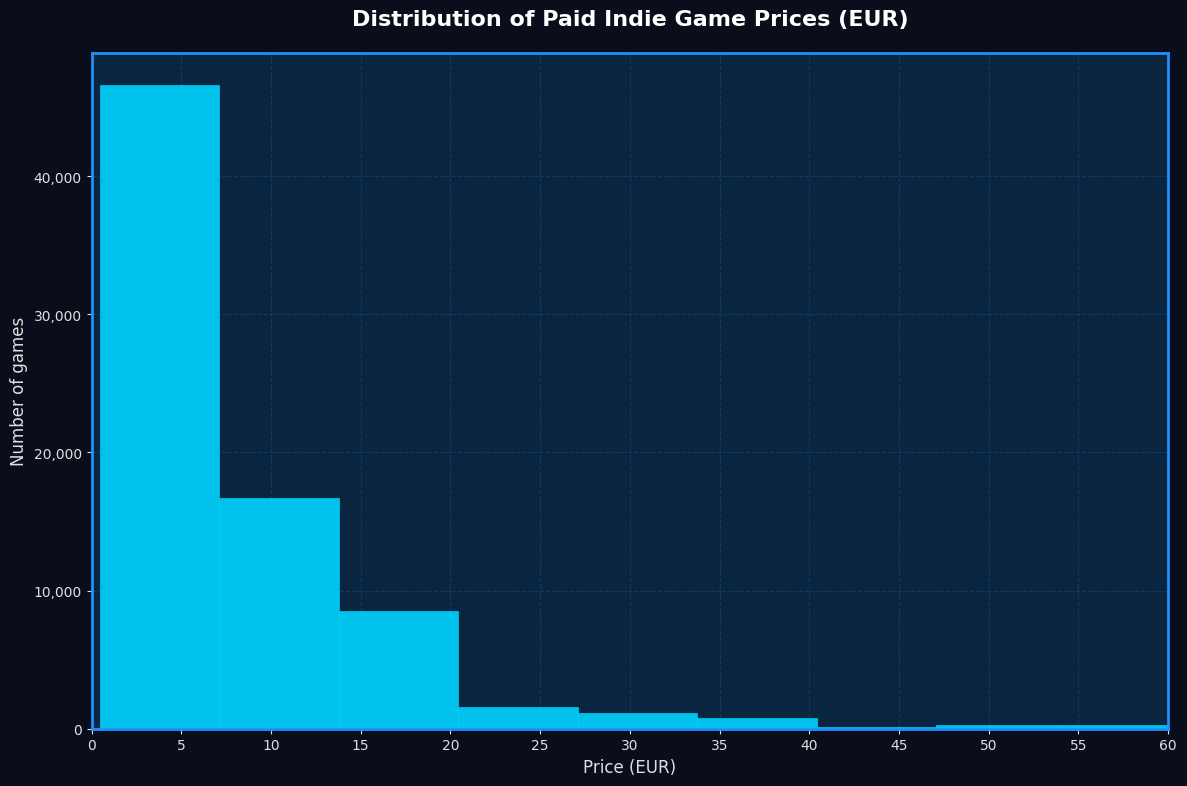

Saved: price_range_buckets.png


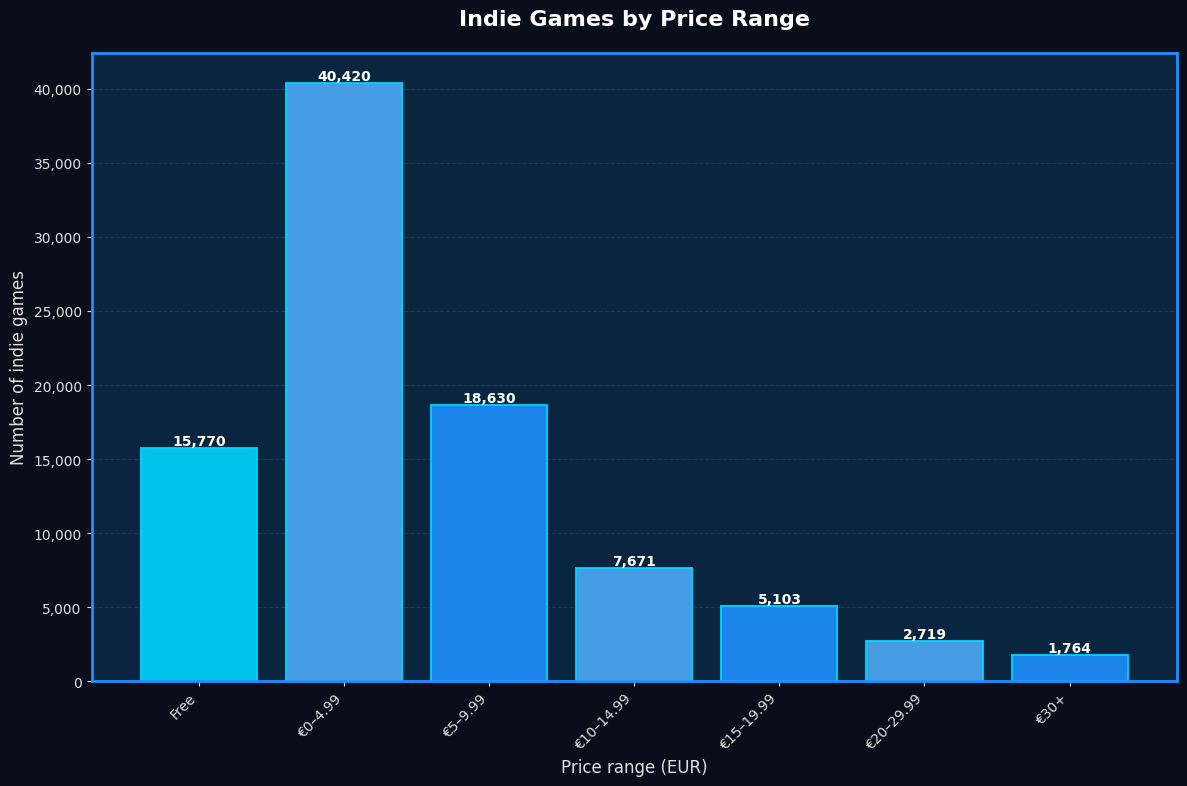

In [3]:
# This cell is needed for Q2
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# DARK THEME STYLING - Add this at the very top
# --------------------------------------------------

# Define your website's color scheme
COLORS = {
    'bg_dark': '#0a0e1a',
    'bg_darker': '#000814',
    'dark_blue': '#0a2540',
    'primary_blue': '#1e90ff',
    'accent_blue': '#00d4ff',
    'light_blue': '#4dabf7',
    'text_light': '#e0e0e0',
    'text_white': '#ffffff',
    'grid_color': 'rgba(30, 144, 255, 0.2)'
}

# Set global matplotlib style
plt.style.use('dark_background')

def setup_dark_style():
    """Apply consistent dark styling to all plots"""
    plt.rcParams.update({
        'figure.facecolor': COLORS['bg_dark'],
        'axes.facecolor': COLORS['dark_blue'],
        'axes.edgecolor': COLORS['primary_blue'],
        'axes.labelcolor': COLORS['text_light'],
        'text.color': COLORS['text_white'],
        'xtick.color': COLORS['text_light'],
        'ytick.color': COLORS['text_light'],
        'grid.color': COLORS['primary_blue'],
        'grid.alpha': 0.3,
        'figure.edgecolor': COLORS['primary_blue'],
        'axes.linewidth': 2,
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
    })

def save_for_web(fig, filename):
    """Save figure with web-optimized settings"""
    fig.savefig(filename, 
                dpi=150, 
                bbox_inches='tight', 
                facecolor=COLORS['bg_dark'],
                edgecolor=COLORS['primary_blue'],
                pad_inches=0.2)
    print(f"Saved: {filename}")

# Apply the dark theme
setup_dark_style()

# --------------------------------------------------
# Load and parse (your existing code)
# --------------------------------------------------
df = pd.read_csv(
    "games.csv",
    sep=',',
    quotechar='"',
    escapechar='\\',
    on_bad_lines="skip",
    engine='python'
)

df.columns = df.columns.str.strip().str.replace('"', '', regex=False)

def extract_price_and_currency(x):
    if pd.isna(x) or x == '\\N' or x == 'N':
        return None, None
    
    try:
        x = str(x)
        
        # Extract price
        price_match = re.search(r'["\']?final["\']?\s*:\s*(\d+)', x)
        price = int(price_match.group(1)) / 100 if price_match else None
        
        # Extract currency
        currency_match = re.search(r'["\']?currency["\']?\s*:\s*["\']([A-Z]{3})["\']', x)
        currency = currency_match.group(1) if currency_match else None
        
        return price, currency
        
    except Exception:
        return None, None

df[["price", "currency"]] = df["price_overview"].apply(
    lambda x: pd.Series(extract_price_and_currency(x))
)

# --------------------------------------------------
# Exchange rates to EUR (as of Dec 31, 2024)
# --------------------------------------------------
exchange_rates_to_eur = {
    'EUR': 1.0,
    'USD': 1 / 1.0389,
    'GBP': 1 / 0.82918,
    'JPY': 1 / 163.06,
    'CAD': 1 / 1.4785,
    'AUD': 1 / 1.6631,
    'CHF': 1 / 0.9367,
    'CNY': 1 / 7.5496,
    'SEK': 1 / 11.4840,
    'NZD': 1 / 1.8417,
    'MXN': 1 / 21.2110,
    'SGD': 1 / 1.4159,
    'HKD': 1 / 8.0726,
    'NOK': 1 / 11.8500,
    'KRW': 1 / 1518.82,
    'TRY': 1 / 36.7285,
    'RUB': 1 / 103.50,
    'INR': 1 / 89.05,
    'BRL': 1 / 6.32,
    'ZAR': 1 / 19.2520,
    'DKK': 1 / 7.4578,
    'PLN': 1 / 4.2625,
    'THB': 1 / 35.54,
    'MYR': 1 / 4.67,
    'HUF': 1 / 410.25,
    'CZK': 1 / 25.185,
    'ILS': 1 / 3.82,
    'CLP': 1 / 1023.50,
    'PHP': 1 / 60.85,
    'AED': 1 / 3.814,
    'COP': 1 / 4562.00,
    'SAR': 1 / 3.896,
    'VND': 1 / 26380,
}

# --------------------------------------------------
# Convert all prices to EUR and round to 2 decimals
# --------------------------------------------------
def convert_to_eur(row):
    # 1. If the price is already 0 (free games), return 0 immediately
    if row['price'] == 0:
        return 0.0
    
    # 2. If price or currency is missing, return 0 as requested
    if pd.isna(row['price']) or pd.isna(row['currency']):
        return 0.0
    
    # 3. Look up the exchange rate
    rate = exchange_rates_to_eur.get(row['currency'])
    
    # 4. If currency is not in our dictionary, return 0
    if rate is None:
        return 0.0
    
    return round(row['price'] * rate, 2)

df.loc[df['is_free'] == 1, 'price'] = 0
df['price_eur'] = df.apply(convert_to_eur, axis=1)
df['price_eur'] = df['price_eur'].fillna(0)
df['price'] = df['price'].fillna(0)

# --------------------------------------------------
# Results
# --------------------------------------------------
print("=== CONVERSION RESULTS ===\n")
print(f"Total games: {len(df):,}")
print(f"Games with non-zero EUR prices: {(df['price_eur'] > 0).sum():,}")
print(f"Conversion success rate: {df['price_eur'].notna().sum() / len(df) * 100:.1f}%")

print("\n=== SAMPLE ===")
print(df[['name', 'price', 'currency', 'price_eur','type']].head())

print("\n=== PRICE STATISTICS (in EUR) ===")
print(df['price_eur'].describe())

print("\n=== TOP 10 MOST EXPENSIVE GAMES ===")
most_expensive = df.nlargest(10, 'price_eur')[['name', 'price_eur', 'currency', 'release_date']]
print(most_expensive)
print(f"Loaded rows: {len(df)}")

df_games = df[df["type"] == "game"].copy()
df_games = df_games.drop(columns=['price_overview', 'release_date','type','languages'])
print(df_games.columns)
print(df_games.head(35))

# --------------------------------------------------
# Q2 ANALYSIS — PRICE DISTRIBUTION
# --------------------------------------------------

# 1️⃣ Explicitly mark free games
df_games.loc[df_games["is_free"] == True, "price_bucket"] = "Free"

# 2️⃣ Bucket paid games ONLY
paid_mask = (df_games["is_free"] == False) & (df_games["price_eur"]>0)

bins = [0, 5, 10, 15, 20, 30, np.inf]
labels = [
    "€0–4.99",
    "€5–9.99",
    "€10–14.99",
    "€15–19.99",
    "€20–29.99",
    "€30+"
]

df_games.loc[paid_mask, "price_bucket"] = pd.cut(
    df_games.loc[paid_mask, "price_eur"],
    bins=bins,
    labels=labels,
    right=False
)

# --------------------------------------------------
# PLOT 1 — Histogram (PAID games only) - DARK THEME
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 8))

# Get the paid games data
paid_prices = df_games.loc[paid_mask, "price_eur"]

# Create histogram with gradient colors
n, bins_array, patches = ax.hist(
    paid_prices, 
    bins=150, 
    edgecolor=COLORS['accent_blue'], 
    linewidth=0.5,
    alpha=0.9
)

# Apply gradient coloring to histogram bars
for i, patch in enumerate(patches):
    if i < len(patches) // 3:
        patch.set_facecolor(COLORS['accent_blue'])
    elif i < 2 * len(patches) // 3:
        patch.set_facecolor(COLORS['primary_blue'])
    else:
        patch.set_facecolor(COLORS['light_blue'])

ax.set_xlim(0, 60)
ax.set_xticks(range(0, 61, 5))
ax.set_xlabel("Price (EUR)", fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Number of games", fontsize=12, color=COLORS['text_light'])
ax.set_title("Distribution of Paid Indie Game Prices (EUR)", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Style the grid
ax.grid(True, alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{int(y):,}'))

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

plt.tight_layout()
save_for_web(fig, 'price_distribution_histogram.png')
plt.show()

# --------------------------------------------------
# PLOT 2 — Price buckets (Free INCLUDED) - DARK THEME
# --------------------------------------------------

bucket_order = [
    "Free",
    "€0–4.99",
    "€5–9.99",
    "€10–14.99",
    "€15–19.99",
    "€20–29.99",
    "€30+"
]

bucket_counts = (
    df_games["price_bucket"]
    .value_counts()
    .reindex(bucket_order)
)

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars with custom colors
colors = []
for i, bucket in enumerate(bucket_order):
    if bucket == "Free":
        colors.append(COLORS['accent_blue'])  # Highlight free games
    elif i % 2 == 0:
        colors.append(COLORS['primary_blue'])
    else:
        colors.append(COLORS['light_blue'])

bars = ax.bar(
    bucket_order,
    bucket_counts,
    color=colors,
    edgecolor=COLORS['accent_blue'],
    linewidth=1.5,
    alpha=0.9
)

# Add value labels on top of bars
for bar, count in zip(bars, bucket_counts):
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=COLORS['text_white'],
            fontweight='bold'
        )

ax.set_xlabel("Price range (EUR)", fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Number of indie games", fontsize=12, color=COLORS['text_light'])
ax.set_title("Indie Games by Price Range", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Style the grid
ax.grid(True, axis='y', alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{int(y):,}'))

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

plt.tight_layout()
save_for_web(fig, 'price_range_buckets.png')
plt.show()

['app_id', 'genre']
   app_id                       name
0      10             Counter-Strike
1      20      Team Fortress Classic
2      30              Day of Defeat
3      40         Deathmatch Classic
4      50  Half-Life: Opposing Force
========== this part is for weighted engagement part===========================
Columns in reviews.csv:
['"app_id"', '"review_score"', '"review_score_description"', '"positive"', '"negative"', '"total"', '"metacritic_score"', '"reviews"', '"recommendations"', '"steamspy_user_score"', '"steamspy_score_rank"', '"steamspy_positive"', '"steamspy_negative"']
The number of rows loaded is: 137158

Sample rows:
  "app_id" "review_score" "review_score_description" "positive" "negative"  \
0     "10"            "9"  "Overwhelmingly Positive"   "235403"     "6207"   
1     "20"            "8"            "Very Positive"     "7315"     "1094"   
2     "30"            "8"            "Very Positive"     "6249"      "672"   
3     "40"            "8"            "V

/var/folders/5g/lwhn35h16cz_x3xfvc5gwgb80000gn/T/ipykernel_7850/2069654456.py:197: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  reviews_df = reviews_df.applymap(


   app_id review_score review_score_description  positive  negative     total  \
0      10            9  Overwhelmingly Positive  235403.0    6207.0  241610.0   
1      20            8            Very Positive    7315.0    1094.0    8409.0   
2      30            8            Very Positive    6249.0     672.0    6921.0   
3      40            8            Very Positive    2542.0     524.0    3066.0   
4      50            9  Overwhelmingly Positive   22263.0    1111.0   23374.0   
5      60            8            Very Positive    4791.0    1013.0    5804.0   
6      70            9  Overwhelmingly Positive  129364.0    4652.0  134016.0   
7      80            8            Very Positive   23316.0    2220.0   25536.0   
8     130            8            Very Positive   15859.0    1330.0   17189.0   
9     219            8            Very Positive     132.0      10.0     142.0   

   metacritic_score reviews  recommendations steamspy_user_score  \
0              88.0     NaN         1532

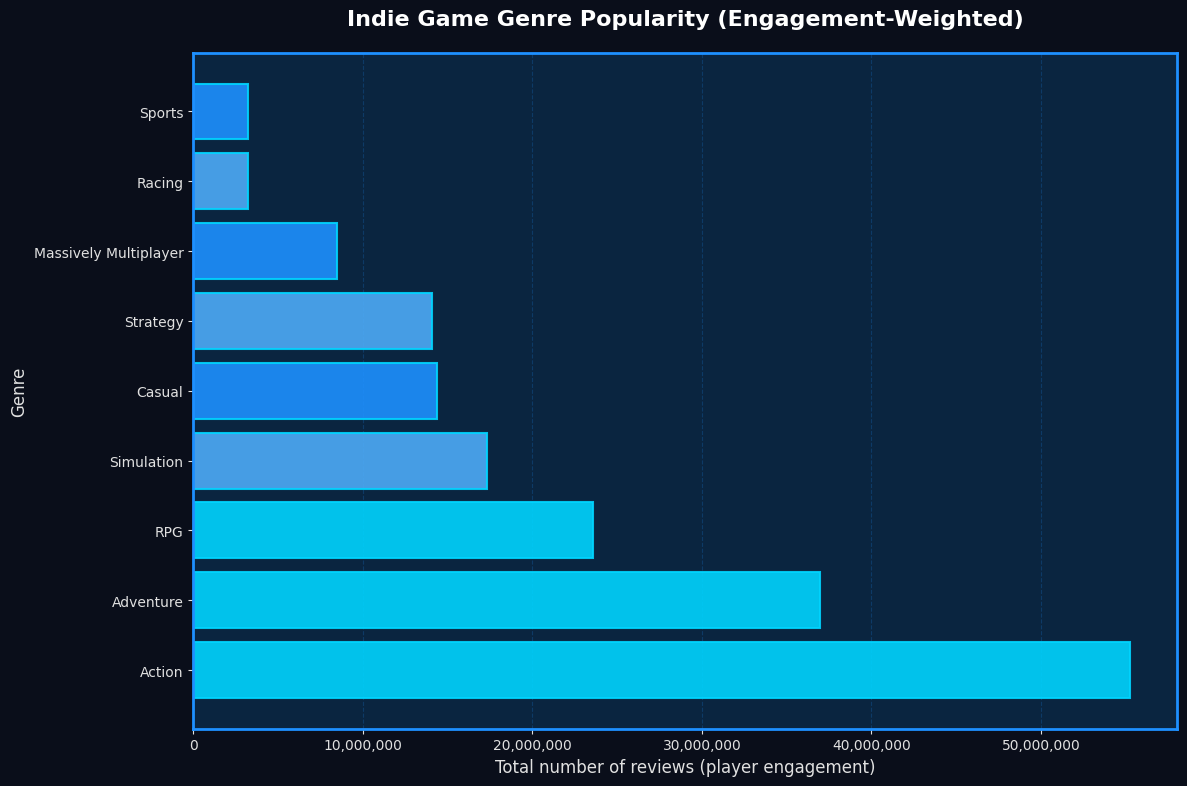

Saved: genre_popularity_count.png


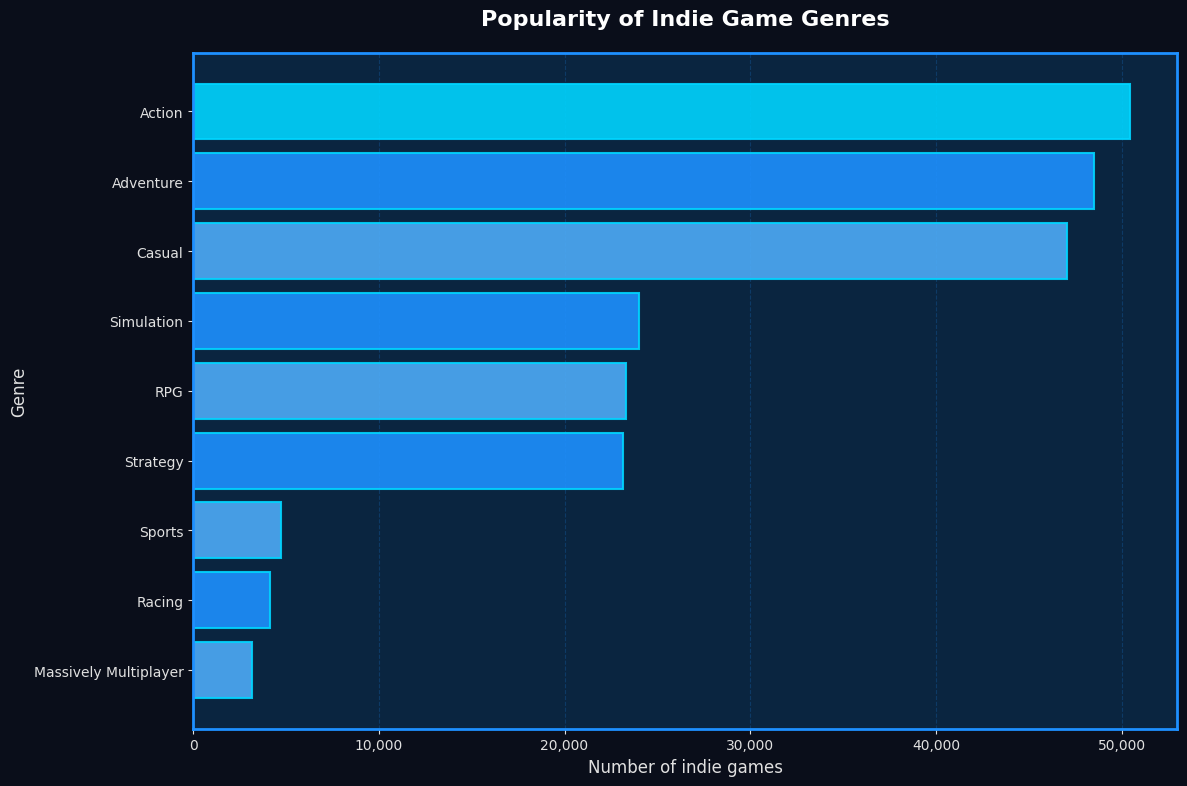

============================== For tags
Saved: top_tags.png


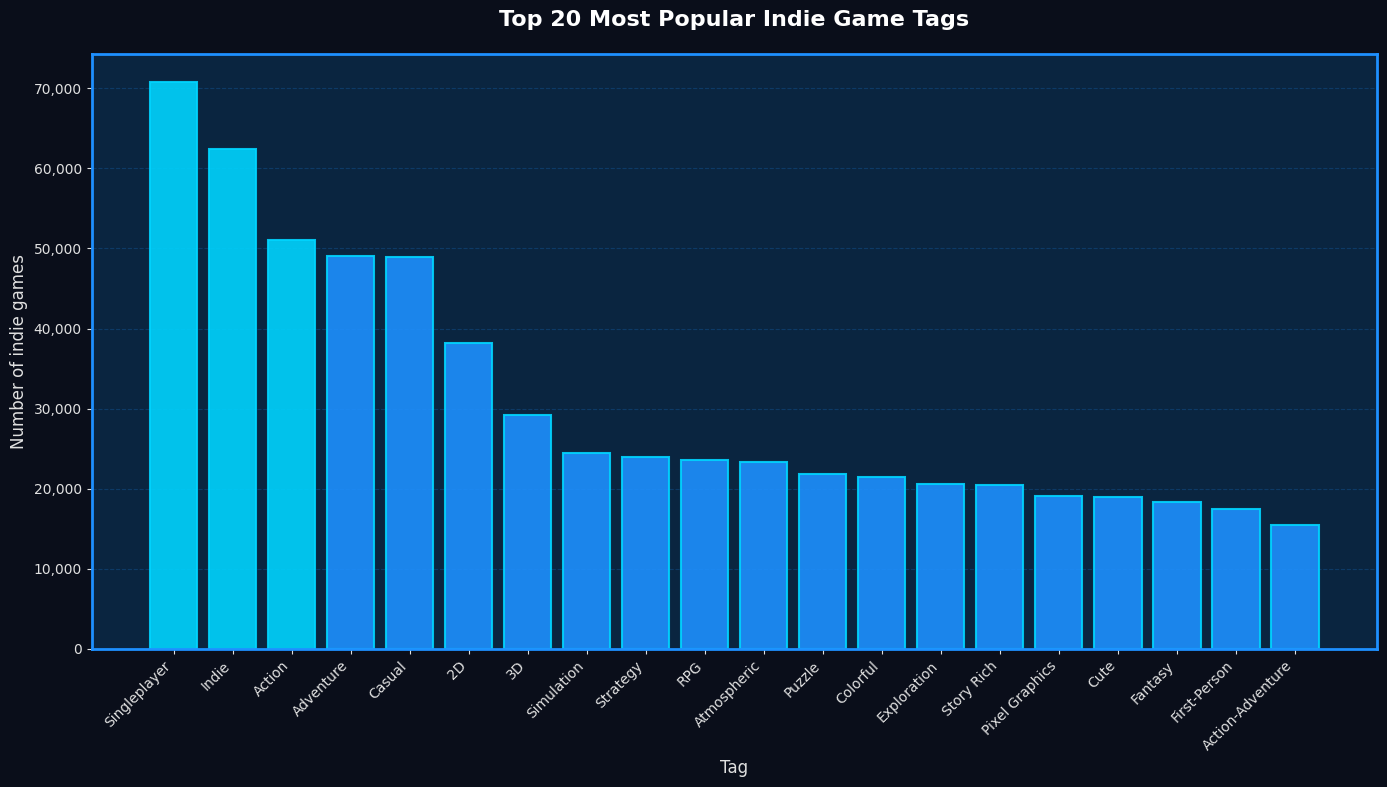

0                     Counter-Strike
1              Team Fortress Classic
2                      Day of Defeat
3                 Deathmatch Classic
4          Half-Life: Opposing Force
                     ...            
140077                    Hacky Demo
140078          Quantum of Hope Demo
140079        A Night With: Succubus
140080                 心所向往的北极星 Demo
140081    S.X.E. Slider: Hard Ridin'
Name: name, Length: 140082, dtype: object


In [2]:
# This cell is for answering Q1
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# DARK THEME STYLING - Add this at the very top
# --------------------------------------------------

# Define your website's color scheme
COLORS = {
    'bg_dark': '#0a0e1a',
    'bg_darker': '#000814',
    'dark_blue': '#0a2540',
    'primary_blue': '#1e90ff',
    'accent_blue': '#00d4ff',
    'light_blue': '#4dabf7',
    'text_light': '#e0e0e0',
    'text_white': '#ffffff',
    'grid_color': 'rgba(30, 144, 255, 0.2)'
}

# Set global matplotlib style
plt.style.use('dark_background')

def setup_dark_style():
    """Apply consistent dark styling to all plots"""
    plt.rcParams.update({
        'figure.facecolor': COLORS['bg_dark'],
        'axes.facecolor': COLORS['dark_blue'],
        'axes.edgecolor': COLORS['primary_blue'],
        'axes.labelcolor': COLORS['text_light'],
        'text.color': COLORS['text_white'],
        'xtick.color': COLORS['text_light'],
        'ytick.color': COLORS['text_light'],
        'grid.color': COLORS['primary_blue'],
        'grid.alpha': 0.3,
        'figure.edgecolor': COLORS['primary_blue'],
        'axes.linewidth': 2,
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
    })

def save_for_web(fig, filename):
    """Save figure with web-optimized settings"""
    fig.savefig(filename, 
                dpi=150, 
                bbox_inches='tight', 
                facecolor=COLORS['bg_dark'],
                edgecolor=COLORS['primary_blue'],
                pad_inches=0.2)
    print(f"Saved: {filename}")

# Apply the dark theme
setup_dark_style()

# --------------------------------------------------
# Load and parse (your existing code)
# --------------------------------------------------
df = pd.read_csv(
    "games.csv",
    sep=',',
    quotechar='"',
    escapechar='\\',
    on_bad_lines="skip",
    engine='python'
)
reviews_df = pd.read_csv(
    "reviews.csv",
    sep=",",
    engine="python",
    quoting=3,              # csv.QUOTE_NONE
    escapechar="\\",
    on_bad_lines="skip",
    encoding="utf-8",
)

df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
genres_df = pd.read_csv(
    "genres.csv",
    sep=",",
    quotechar='"',
    engine="python"
)

print(genres_df.columns.tolist())

tags_df = pd.read_csv(
    "tags.csv",
    engine="python",
    sep = ",",
    quotechar='"'
)

# To improve safety
genres_df["genre"] = genres_df["genre"].str.strip()
tags_df["tag"] = tags_df["tag"].str.strip()

df_games = df[df["type"] == "game"][["app_id", "name"]].copy()
print("========================================")
print(df_games.head())

# Merge table using inner join
genres_indie = genres_df.merge(df_games, on="app_id", how="inner")
tags_indie = tags_df.merge(df_games, on="app_id", how="inner")

# Excluded Genres
EXCLUDED_GENRES = {
    "Indie",
    "Early Access",
    "Free To Play",
    "Free to Play",
    "Utilities",
    "Software",
    "Animation & Modeling",
    "Design & Illustration",
    "Education",
    "Audio Production",
    "Video Production",
    "Web Publishing",
    "Accounting",
    "Photo Editing",
    "Game Development",
    "Tutorial"
}

CANONICAL_GENRES = {
    "Action": ["Actie", "Ackja", "Azione","Action"],
    "Adventure": ["Aventura", "Abenteuer","Aventure","Avontuur","Eventyr","Avventura","Seikkailu","Adventure"],
    "RPG": ["Rollenspiel", "Rol", "GDR","Roolipelit","RPG"],
    "Strategy": ["Strategie", "Estrategia", "Strategia","Strategi","Strategy"],
    "Simulation": ["Simuladores", "Simulationen", "Simulatie","Simulaatio","Simulering","Simulation"],
    "Casual": ["Gelegenheitsspiele", "Occasionnel", "Passatempo","Casual"],
    "Racing": ["Carreras","Course automobile","Race","Racing"],
    "Sports": ["Deportes", "Sport"],
    "Massively Multiplayer": ["Multijugador masivo","Massivement multijoueur","MMO","Massively Multiplayer"],
}

def normalize_genre(raw_genre):
    g = raw_genre.strip()
    for canonical, variants in CANONICAL_GENRES.items():
        for v in variants:
            if v in g:
                return canonical
    return None

genres_filtered = genres_indie[
    ~genres_indie["genre"].isin(EXCLUDED_GENRES)
].copy()
genres_filtered["genre_normalized"] = genres_filtered["genre"].apply(normalize_genre)

genres_clean = genres_filtered.dropna(subset=["genre_normalized"])

genre_counts = (
    genres_clean["genre_normalized"]
    .value_counts()
    .reset_index()
)
genre_counts.columns = ["genre", "game_count"]
genre_counts["genre"] = genre_counts["genre"].astype(str)
genre_counts.columns = ["genre", "game_count"]
unique_values = genre_counts.genre.unique()

print("========== this part is for weighted engagement part===========================")
print("Columns in reviews.csv:")
print(reviews_df.columns.tolist())
print(f"The number of rows loaded is: {len(reviews_df)}")
print("\nSample rows:")
print(reviews_df.head())

# Clean column names
reviews_df.columns = reviews_df.columns.str.replace('"', '', regex=False)

# Convert numeric columns
numeric_cols = [
    "positive", "negative", "total",
    "recommendations", "metacritic_score"
]
for col in reviews_df.columns:
    reviews_df[col] = (
        reviews_df[col]
        .astype(str)
        .str.replace('"', '', regex=False)
        .replace('N', np.nan)
    )

for col in numeric_cols:
    reviews_df[col] = pd.to_numeric(reviews_df[col], errors="coerce")

# Remove quotes from all string cells
reviews_df = reviews_df.applymap(
    lambda x: x.replace('"', '') if isinstance(x, str) else x
)

reviews_df["app_id"] = pd.to_numeric(
    reviews_df["app_id"],
    errors="coerce"
)
reviews_df = reviews_df.dropna(subset=["app_id"])
reviews_df["app_id"] = reviews_df["app_id"].astype(int)
print(reviews_df.head(10))
print(reviews_df.dtypes)
print(reviews_df.head())

genres_with_reviews = genres_clean.merge(
    reviews_df[["app_id", "total"]],
    on="app_id",
    how="left"
)

genres_with_reviews["total"] = genres_with_reviews["total"].fillna(0)

genre_popularity = (
    genres_with_reviews
    .groupby("genre_normalized")
    .agg(
        games_count=("app_id", "nunique"),
        total_reviews=("total", "sum"),
        avg_reviews_per_game=("total", "mean")
    )
    .sort_values("total_reviews", ascending=False)
    .reset_index()
)

print(genre_popularity)

# --------------------------------------------------
# PLOT 1: Genre Popularity (Engagement-Weighted) - DARK THEME
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars with alternating colors
colors = [COLORS['primary_blue'] if i % 2 == 0 else COLORS['light_blue'] 
          for i in range(len(genre_popularity))]

bars = ax.barh(
    genre_popularity["genre_normalized"],
    genre_popularity["total_reviews"],
    color=colors,
    edgecolor=COLORS['accent_blue'],
    linewidth=1.5,
    alpha=0.9
)

# Highlight top 3 genres
for i in range(min(3, len(bars))):
    bars[i].set_color(COLORS['accent_blue'])

ax.set_xlabel("Total number of reviews (player engagement)", 
              fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Genre", fontsize=12, color=COLORS['text_light'])
ax.set_title("Indie Game Genre Popularity (Engagement-Weighted)", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Style the grid
ax.grid(True, axis='x', alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Format x-axis with commas for readability
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

plt.tight_layout()
save_for_web(fig, 'genre_popularity_weighted.png')
plt.show()

# --------------------------------------------------
# PLOT 2: Popularity of Indie Game Genres - DARK THEME
# --------------------------------------------------
genre_counts = genre_counts.sort_values("game_count", ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars with gradient colors
colors = [COLORS['light_blue'] if i % 2 == 0 else COLORS['primary_blue'] 
          for i in range(len(genre_counts))]

bars = ax.barh(
    genre_counts["genre"],
    genre_counts["game_count"],
    color=colors,
    edgecolor=COLORS['accent_blue'],
    linewidth=1.5,
    alpha=0.9
)

# Highlight top genre
bars[-1].set_color(COLORS['accent_blue'])

ax.set_xlabel("Number of indie games", fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Genre", fontsize=12, color=COLORS['text_light'])
ax.set_title("Popularity of Indie Game Genres", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Style the grid
ax.grid(True, axis='x', alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

plt.tight_layout()
save_for_web(fig, 'genre_popularity_count.png')
plt.show()

# --------------------------------------------------
# Tags Analysis
# --------------------------------------------------
print("============================== For tags")
tag_counts = (
    tags_indie["tag"]
    .value_counts()
    .reset_index()
)

tag_counts.columns = ["tag", "game_count"]
top_tags = tag_counts.head(20)

# --------------------------------------------------
# PLOT 3: Top 20 Tags - DARK THEME
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Create bars
bars = ax.bar(
    top_tags["tag"],
    top_tags["game_count"],
    color=COLORS['primary_blue'],
    edgecolor=COLORS['accent_blue'],
    linewidth=1.5,
    alpha=0.9
)

# Highlight top 5 tags
max_count = top_tags["game_count"].max()
for bar, count in zip(bars, top_tags["game_count"]):
    if count > max_count * 0.7:
        bar.set_color(COLORS['accent_blue'])

ax.set_xlabel("Tag", fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Number of indie games", fontsize=12, color=COLORS['text_light'])
ax.set_title("Top 20 Most Popular Indie Game Tags", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Style the grid
ax.grid(True, axis='y', alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{int(y):,}'))

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

plt.tight_layout()
save_for_web(fig, 'top_tags.png')
plt.show()

print(df["name"])

   language_normalized        total
0                Other  547535773.0
1              Chinese  107863373.0
2              Spanish  105676731.0
3           Portuguese   90649636.0
4              English   88623575.0
5               German   75794373.0
6               French   74599401.0
7              Russian   71300002.0
8              Italian   63387259.0
9             Japanese   59764214.0
10              Korean   49731026.0


/var/folders/5g/lwhn35h16cz_x3xfvc5gwgb80000gn/T/ipykernel_7850/891604426.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_engagement_no_other["share"] = (


Saved: language_engagement.png


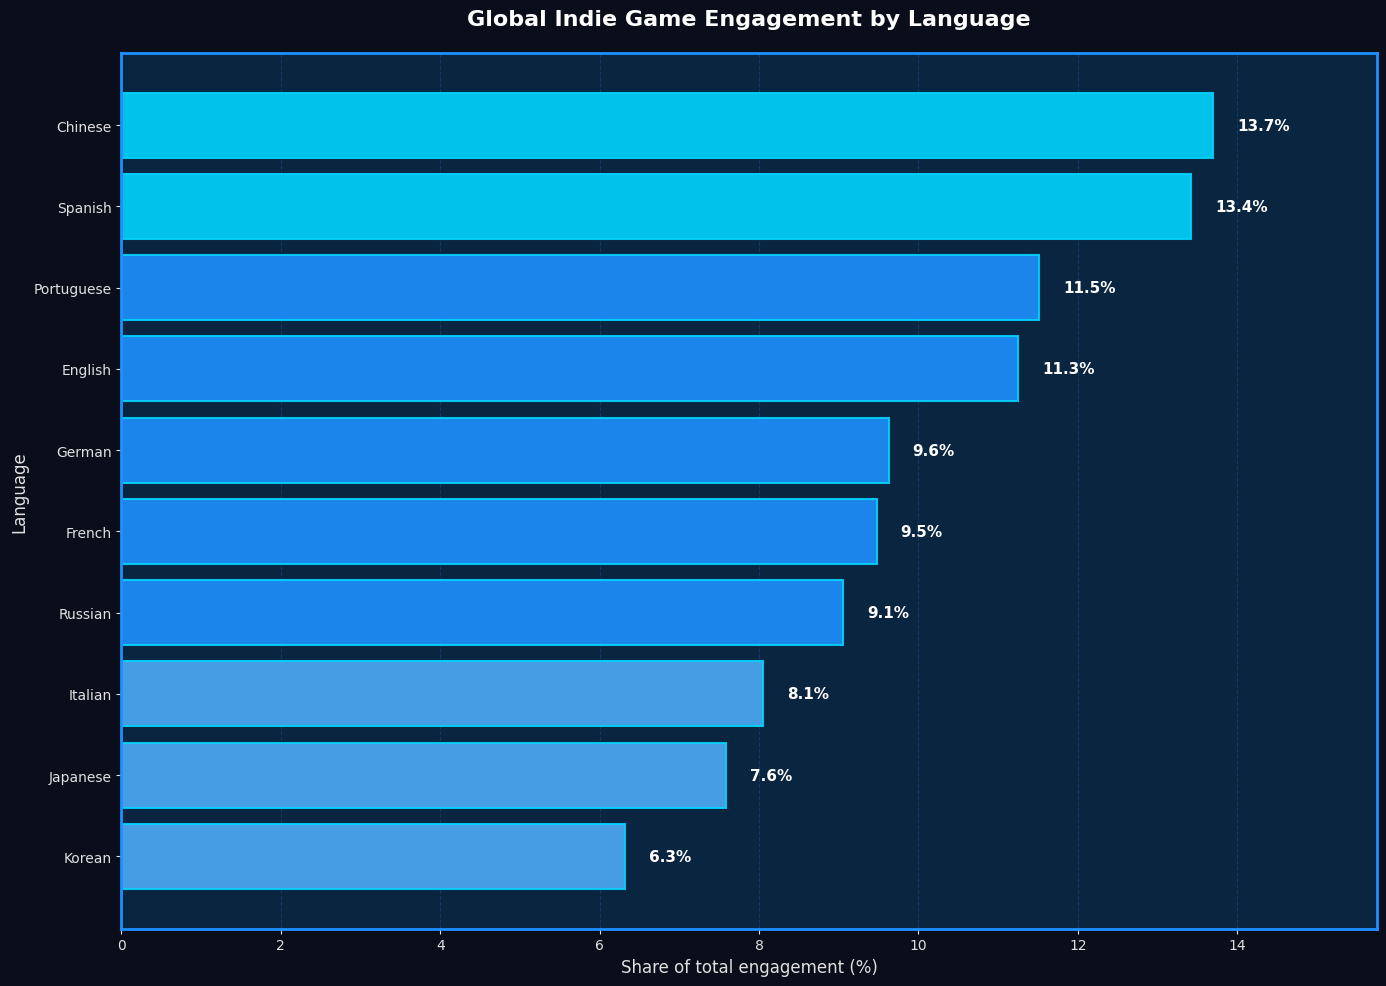

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --------------------------------------------------
# DARK THEME STYLING - Add this at the very top
# --------------------------------------------------

# Define your website's color scheme
COLORS = {
    'bg_dark': '#0a0e1a',
    'bg_darker': '#000814',
    'dark_blue': '#0a2540',
    'primary_blue': '#1e90ff',
    'accent_blue': '#00d4ff',
    'light_blue': '#4dabf7',
    'text_light': '#e0e0e0',
    'text_white': '#ffffff',
    'grid_color': 'rgba(30, 144, 255, 0.2)'
}

# Set global matplotlib style
plt.style.use('dark_background')

def setup_dark_style():
    """Apply consistent dark styling to all plots"""
    plt.rcParams.update({
        'figure.facecolor': COLORS['bg_dark'],
        'axes.facecolor': COLORS['dark_blue'],
        'axes.edgecolor': COLORS['primary_blue'],
        'axes.labelcolor': COLORS['text_light'],
        'text.color': COLORS['text_white'],
        'xtick.color': COLORS['text_light'],
        'ytick.color': COLORS['text_light'],
        'grid.color': COLORS['primary_blue'],
        'grid.alpha': 0.3,
        'figure.edgecolor': COLORS['primary_blue'],
        'axes.linewidth': 2,
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
    })

def save_for_web(fig, filename):
    """Save figure with web-optimized settings"""
    fig.savefig(filename, 
                dpi=150, 
                bbox_inches='tight', 
                facecolor=COLORS['bg_dark'],
                edgecolor=COLORS['primary_blue'],
                pad_inches=0.2)
    print(f"Saved: {filename}")

# Apply the dark theme
setup_dark_style()

# --------------------------------------------------
# Load Data
# --------------------------------------------------

# Load games
games_df = pd.read_csv(
    "games.csv",
    sep=",",
    quotechar='"',
    escapechar="\\",
    engine="python",
    on_bad_lines="skip"
)

reviews_df = pd.read_csv(
    "reviews.csv",
    sep=",",
    engine="python",
    quoting=3,              # csv.QUOTE_NONE
    escapechar="\\",
    on_bad_lines="skip",
    encoding="utf-8",
)

reviews_df.columns = reviews_df.columns.str.replace('"', '', regex=False)
reviews_df["app_id"] = (
    reviews_df["app_id"]
    .astype(str)
    .str.replace('"', '', regex=False)
)
reviews_df["total"] = (
    reviews_df["total"]
    .astype(str)
    .str.replace('"', '', regex=False)
)
reviews_df["app_id"] = pd.to_numeric(reviews_df["app_id"], errors="coerce")
reviews_df["total"] = pd.to_numeric(reviews_df["total"], errors="coerce")
reviews_df = reviews_df.dropna(subset=["app_id"])
reviews_df["app_id"] = reviews_df["app_id"].astype(int)

games_df.columns = games_df.columns.str.strip().str.replace('"', '', regex=False)

# Keep only games
games_df = games_df[games_df["type"] == "game"]

# Keep only needed columns
games_df = games_df[["app_id", "languages"]]

# Drop rows without language info
games_df = games_df.dropna(subset=["languages"])

# Clean language strings
games_df["languages"] = (
    games_df["languages"]
    .str.replace(r"<.*?>", "", regex=True)  # remove HTML tags
    .str.replace("*", "", regex=False)
)

# Split languages into rows
languages_df = (
    games_df
    .assign(language=games_df["languages"].str.split(","))
    .explode("language")
)

languages_df["language"] = languages_df["language"].str.strip()

def clean_language(lang):
    if pd.isna(lang):
        return None

    lang = lang.lower()

    # remove common noise phrases
    lang = re.sub(r'languages with full audio support', '', lang)
    lang = re.sub(r'full audio support', '', lang)
    lang = re.sub(r'idiomas con.*', '', lang)
    lang = re.sub(r'langues avec.*', '', lang)
    lang = re.sub(r'sprachen mit.*', '', lang)

    # remove html tags, brackets, symbols
    lang = re.sub(r'<.*?>', '', lang)
    lang = re.sub(r'\[.*?\]', '', lang)
    lang = re.sub(r'[^a-zA-Z\u4e00-\u9fff\u0400-\u04FF\s]', '', lang)

    # normalize spaces
    lang = re.sub(r'\s+', ' ', lang).strip()

    return lang

languages_df["language_clean"] = languages_df["language"].apply(clean_language)

CANONICAL_LANGUAGES = {
    "English": ["english", "anglais", "englisch", "англий", "英"],
    "Chinese": ["chinese", "中文", "简体", "繁体", "chine"],
    "Russian": ["russian", "рус", "rosyj", "russe"],
    "Japanese": ["japanese", "日本", "japon", "giappon"],
    "Korean": ["korean", "한국", "coré"],
    "Spanish": ["spanish", "españ", "espagn", "hiszp"],
    "French": ["french", "français", "francus", "franz"],
    "German": ["german", "deutsch", "allemand", "niemie"],
    "Portuguese": ["portuguese", "português", "portug"],
    "Italian": ["italian", "italiano", "italien"],
}

def normalize_language(lang):
    if not lang:
        return None

    for canonical, variants in CANONICAL_LANGUAGES.items():
        for v in variants:
            if v in lang:
                return canonical
    return "Other"

languages_df["language_normalized"] = (
    languages_df["language_clean"]
    .apply(normalize_language)
)
languages_df["language_normalized"].value_counts()

total_games = languages_df["app_id"].nunique()
covered_games = languages_df[
    languages_df["language_normalized"] != "Other"
]["app_id"].nunique()
coverage_percentage = (covered_games / total_games) * 100
coverage_percentage

language_game_counts = (
    languages_df
    .groupby("language_normalized")["app_id"]
    .nunique()
    .sort_values(ascending=False)
)

languages_reviews = languages_df.merge(
    reviews_df[["app_id", "total"]],
    on="app_id",
    how="left"
)

language_engagement = (
    languages_reviews
    .groupby("language_normalized")["total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
print(language_engagement)

language_engagement_no_other = language_engagement[
    language_engagement["language_normalized"] != "Other"
]
total_engagement = language_engagement_no_other["total"].sum()

language_engagement_no_other["share"] = (
    language_engagement_no_other["total"] / total_engagement
)

language_engagement_no_other = language_engagement_no_other.sort_values(
    "share", ascending=False
)

language_engagement_no_other["cumulative_share"] = (
    language_engagement_no_other["share"].cumsum()
)
language_engagement_no_other

# Sort for plotting (ascending for horizontal bars)
language_engagement_no_other = language_engagement_no_other.sort_values("share", ascending=True)

# --------------------------------------------------
# PLOT: Language Engagement - DARK THEME
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 10))

# Create gradient colors - highlight top languages
colors = []
shares = language_engagement_no_other["share"] * 100
max_share = shares.max()

for share in shares:
    if share > max_share * 0.85:
        colors.append(COLORS['accent_blue'])  # Top languages
    elif share > max_share * 0.60:
        colors.append(COLORS['primary_blue'])  # High engagement
    else:
        colors.append(COLORS['light_blue'])  # Others

# Create horizontal bar chart
bars = ax.barh(
    language_engagement_no_other["language_normalized"],
    language_engagement_no_other["share"] * 100,
    color=colors,
    edgecolor=COLORS['accent_blue'],
    linewidth=1.5,
    alpha=0.9
)

ax.set_xlabel("Share of total engagement (%)", fontsize=12, color=COLORS['text_light'])
ax.set_ylabel("Language", fontsize=12, color=COLORS['text_light'])
ax.set_title("Global Indie Game Engagement by Language", 
             fontsize=16, color=COLORS['text_white'], pad=20, fontweight='bold')

# Add percentage labels with improved styling
for index, (bar, value) in enumerate(zip(bars, language_engagement_no_other["share"] * 100)):
    width = bar.get_width()
    ax.text(
        width + 0.3,
        bar.get_y() + bar.get_height()/2,
        f"{value:.1f}%",
        ha='left',
        va='center',
        fontsize=11,
        color=COLORS['text_white'],
        fontweight='bold'
    )

# Style the grid
ax.grid(True, axis='x', alpha=0.2, color=COLORS['primary_blue'], linestyle='--')
ax.set_axisbelow(True)

# Add border styling
for spine in ax.spines.values():
    spine.set_edgecolor(COLORS['primary_blue'])
    spine.set_linewidth(2)

# Set x-axis limit to accommodate labels
ax.set_xlim(0, max(language_engagement_no_other["share"] * 100) * 1.15)

plt.tight_layout()
save_for_web(fig, 'language_engagement.png')
plt.show()